In [1]:
import astropy

In [2]:
from astropy.io import fits

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.pyplot import axes

In [4]:
import numpy as np
import time
import math

In [5]:
fitspec = fits.open('spec-2483-53852-0232.fits')
fitspec.info()

Filename: spec-2483-53852-0232.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     139   ()      
  1  COADD         1 BinTableHDU     26   3825R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   [J, J, J, 13A, D, E, E, E, E, E, E, E, E, E, E, J, J, E, E]   


In [6]:
cols = fitspec[1].columns
cols.info()
cols.names

name:
    ['flux', 'loglam', 'ivar', 'and_mask', 'or_mask', 'wdisp', 'sky', 'model']
format:
    ['E', 'E', 'E', 'J', 'J', 'E', 'E', 'E']
unit:
    ['', '', '', '', '', '', '', '']
null:
    ['', '', '', '', '', '', '', '']
bscale:
    ['', '', '', '', '', '', '', '']
bzero:
    ['', '', '', '', '', '', '', '']
disp:
    ['', '', '', '', '', '', '', '']
start:
    ['', '', '', '', '', '', '', '']
dim:
    ['', '', '', '', '', '', '', '']
coord_type:
    ['', '', '', '', '', '', '', '']
coord_unit:
    ['', '', '', '', '', '', '', '']
coord_ref_point:
    ['', '', '', '', '', '', '', '']
coord_ref_value:
    ['', '', '', '', '', '', '', '']
coord_inc:
    ['', '', '', '', '', '', '', '']
time_ref_pos:
    ['', '', '', '', '', '', '', '']


['flux', 'loglam', 'ivar', 'and_mask', 'or_mask', 'wdisp', 'sky', 'model']

In [7]:
data =  fitspec[1].data

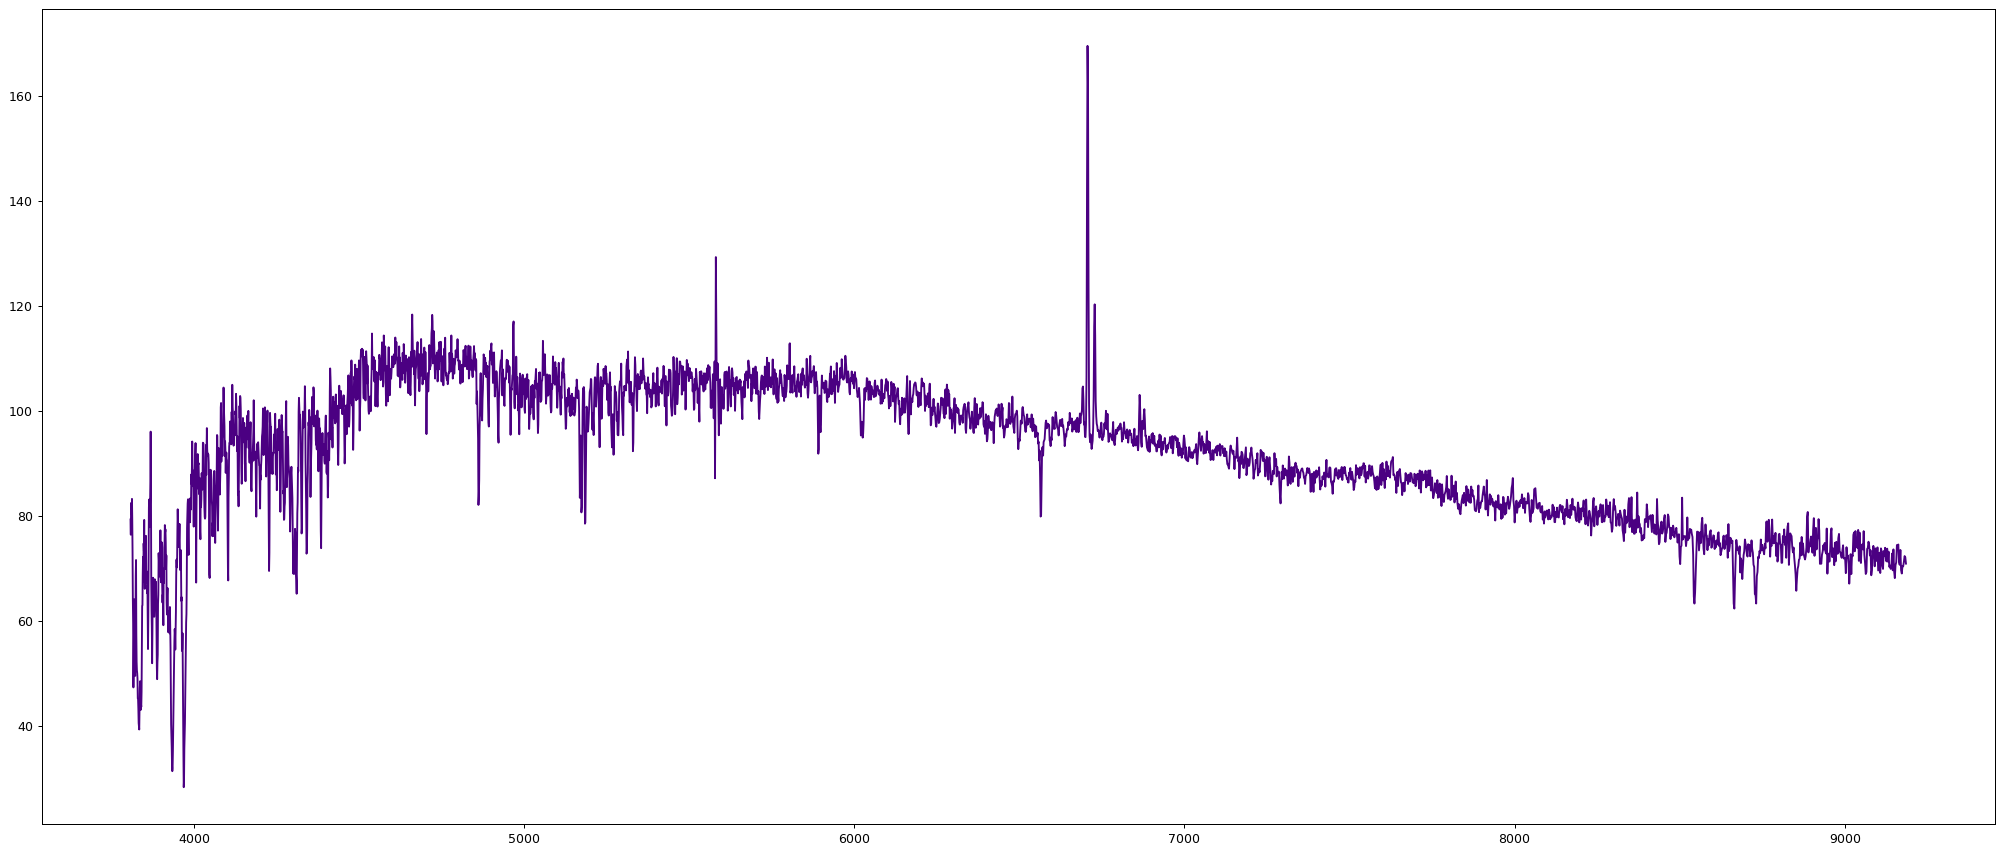

In [8]:
x = data['loglam']
y = data['flux']
x = 10**x
figure(figsize=(28, 12), dpi=90)
plt.plot(x, y, color = 'indigo')

In [9]:
sky = data['sky']
sky = -sky/100

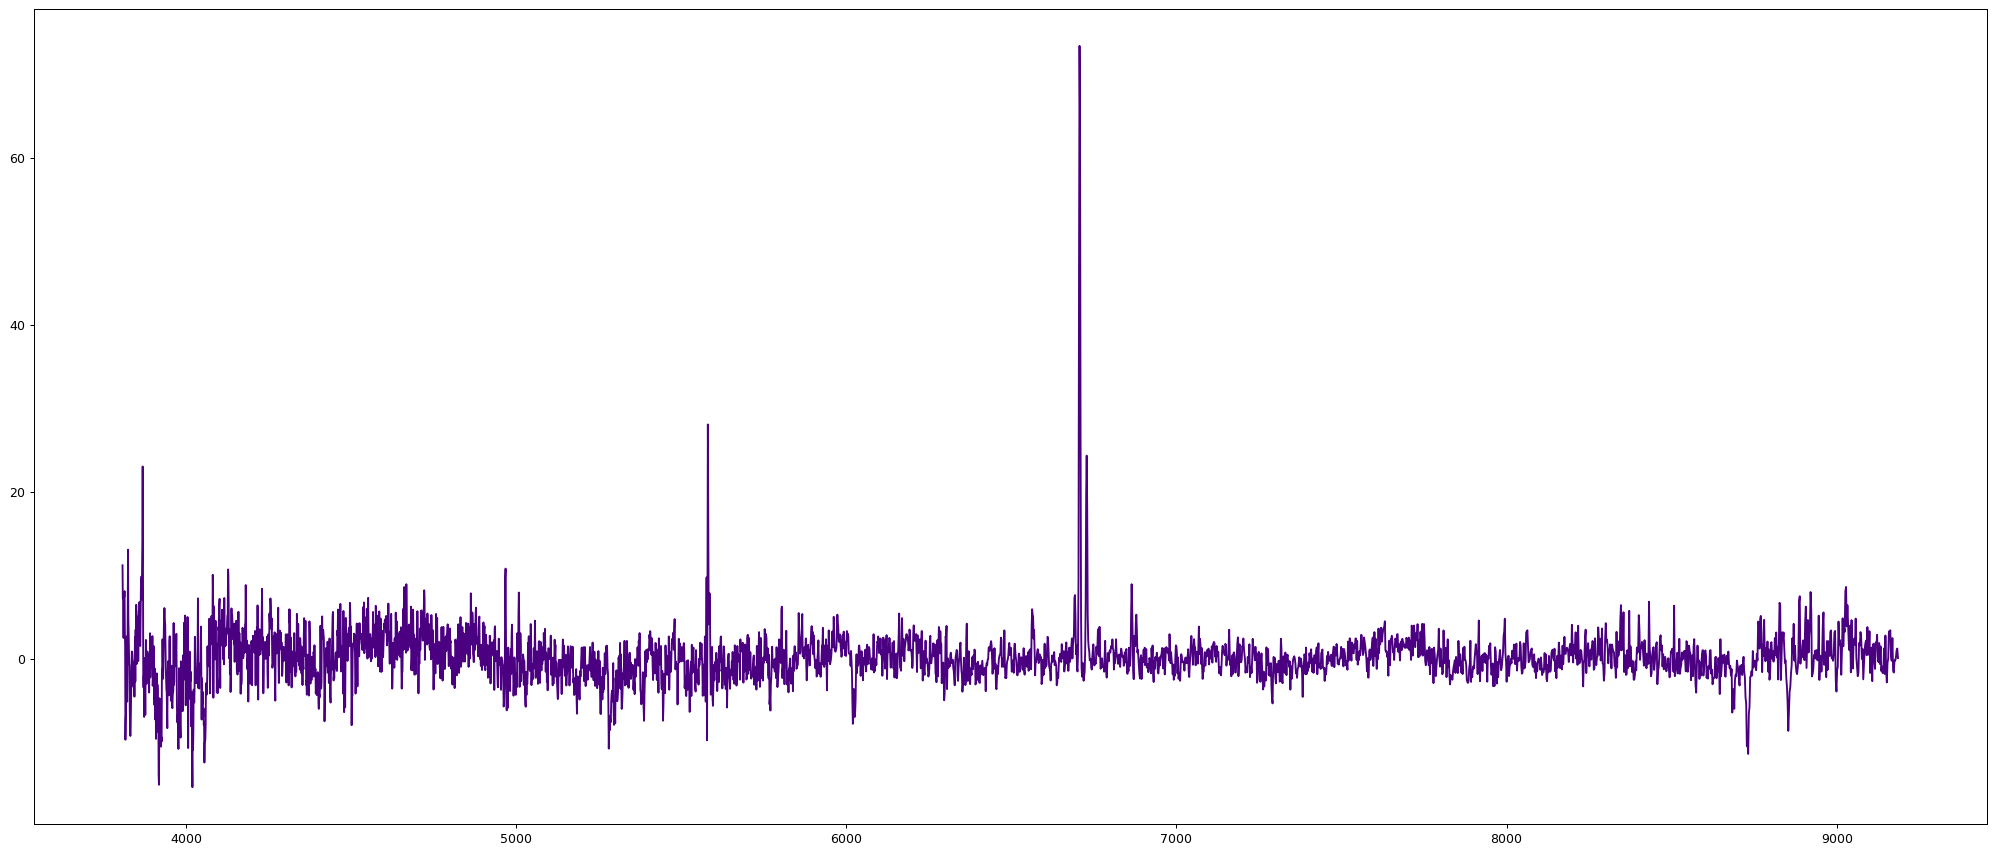

In [11]:
x = data['loglam']
x = 10**x
y = data['flux'] - data['model']
y = y-sky
figure(figsize=(28, 12), dpi=90)
plt.plot(x, y, color = 'indigo')
#plt.plot(x, y-sky, color = 'yellow')

In [12]:
x_l = data['loglam']
x_l = 10**x_l
y_l = data['flux'] - data['model'] -sky

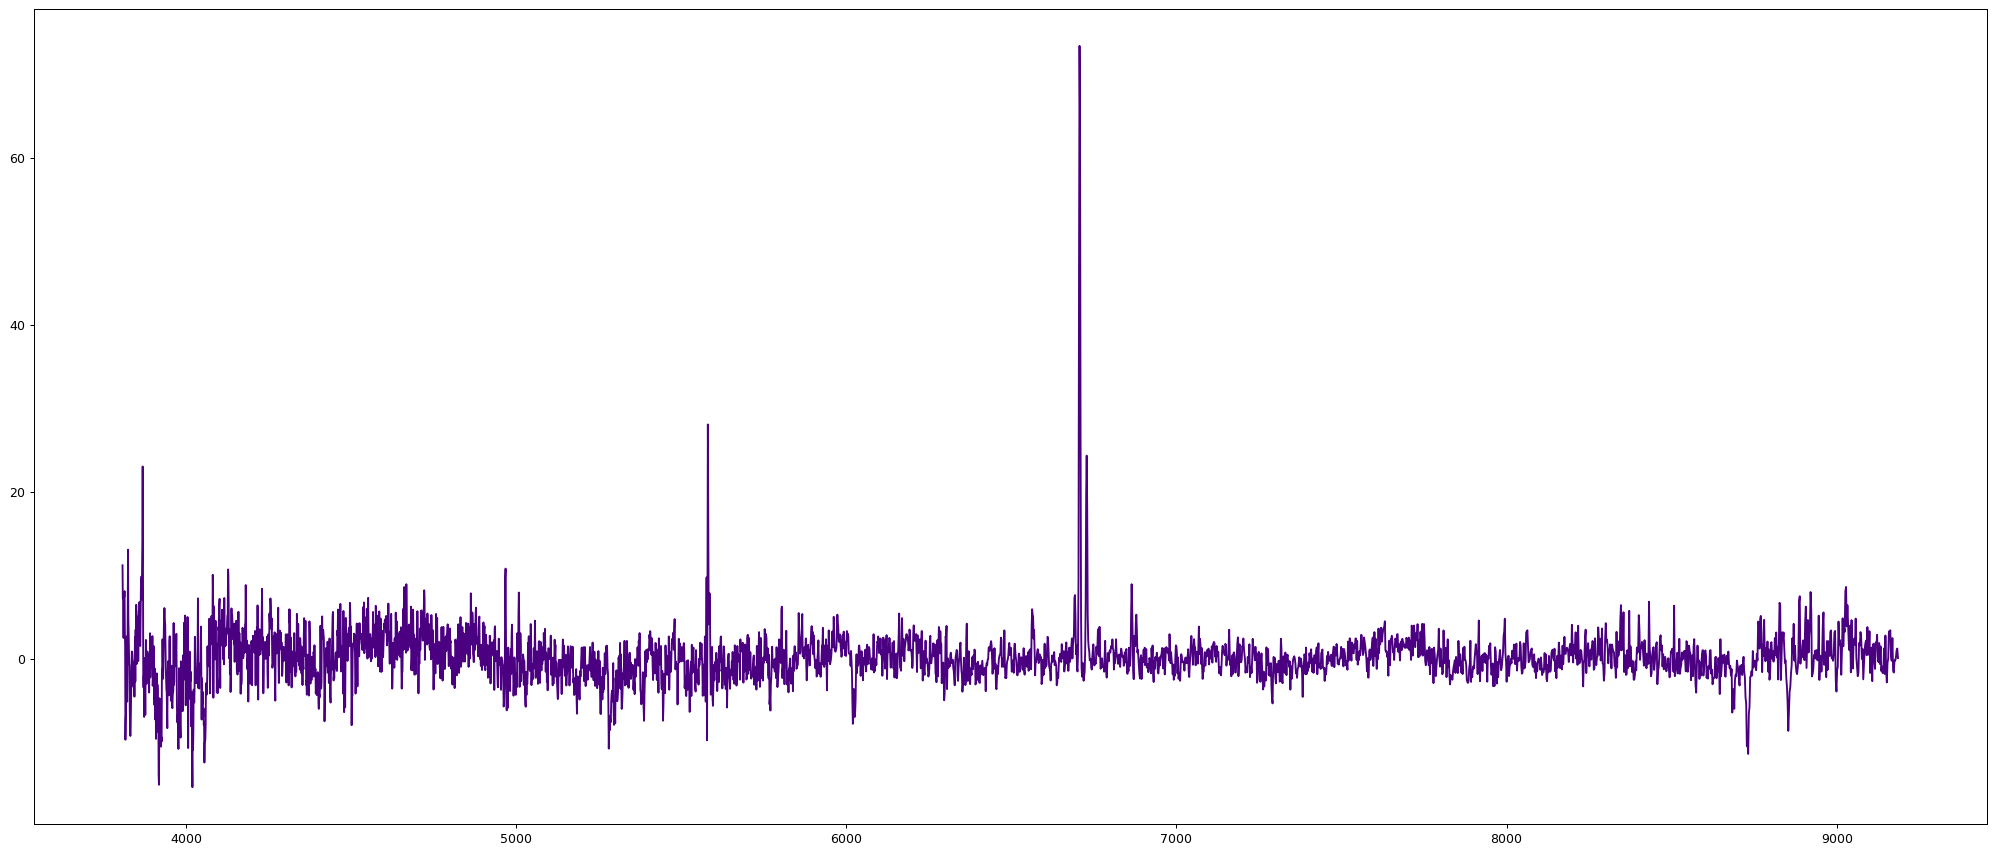

In [13]:
figure(figsize=(28, 12), dpi=90)
plt.plot(x_l, y_l, color = 'indigo')

In [14]:
#следующая функция и класс были написаны другим человеком

In [15]:
def tricubic(x0):
    y0 = np.zeros_like(x0)
    idx = (x0 >= -1) & (x0 <= 1)
    y0[idx] = np.power(1.0 - np.power(np.abs(x0[idx]), 3), 3)
    return y0

In [16]:
class Loess(object):

    @staticmethod
    def normalize_array(array):
        min_val = np.min(array)
        max_val = np.max(array)
        return (array - min_val) / (max_val - min_val), min_val, max_val

    def __init__(self, xx, yy, degree=1):
        self.n_xx, self.min_xx, self.max_xx = self.normalize_array(xx)
        self.n_yy, self.min_yy, self.max_yy = self.normalize_array(yy)
        self.degree = degree

    @staticmethod
    def get_min_range(distances, window):
        min_idx = np.argmin(distances)
        n = len(distances)
        if min_idx == 0:
            return np.arange(0, window)
        if min_idx == n-1:
            return np.arange(n - window, n)

        min_range = [min_idx]
        while len(min_range) < window:
            i0 = min_range[0]
            i1 = min_range[-1]
            if i0 == 0:
                min_range.append(i1 + 1)
            elif i1 == n-1:
                min_range.insert(0, i0 - 1)
            elif distances[i0-1] < distances[i1+1]:
                min_range.insert(0, i0 - 1)
            else:
                min_range.append(i1 + 1)
        return np.array(min_range)

    @staticmethod
    def get_weights(distances, min_range):
        max_distance = np.max(distances[min_range])
        weights = tricubic(distances[min_range] / max_distance)
        return weights

    def normalize_x(self, value):
        return (value - self.min_xx) / (self.max_xx - self.min_xx)

    def denormalize_y(self, value):
        return value * (self.max_yy - self.min_yy) + self.min_yy

    def estimate(self, x, window, use_matrix=False, degree=1):
        n_x = self.normalize_x(x)
        distances = np.abs(self.n_xx - n_x)
        min_range = self.get_min_range(distances, window)
        weights = self.get_weights(distances, min_range)

        if use_matrix or degree > 1:
            wm = np.multiply(np.eye(window), weights)
            xm = np.ones((window, degree + 1))

            xp = np.array([[math.pow(n_x, p)] for p in range(degree + 1)])
            for i in range(1, degree + 1):
                xm[:, i] = np.power(self.n_xx[min_range], i)

            ym = self.n_yy[min_range]
            xmt_wm = np.transpose(xm) @ wm
            beta = np.linalg.pinv(xmt_wm @ xm) @ xmt_wm @ ym
            y = (beta @ xp)[0]
        else:
            xx = self.n_xx[min_range]
            yy = self.n_yy[min_range]
            sum_weight = np.sum(weights)
            sum_weight_x = np.dot(xx, weights)
            sum_weight_y = np.dot(yy, weights)
            sum_weight_x2 = np.dot(np.multiply(xx, xx), weights)
            sum_weight_xy = np.dot(np.multiply(xx, yy), weights)

            mean_x = sum_weight_x / sum_weight
            mean_y = sum_weight_y / sum_weight

            b = (sum_weight_xy - mean_x * mean_y * sum_weight) / \
                (sum_weight_x2 - mean_x * mean_x * sum_weight)
            a = mean_y - b * mean_x
            y = a + b * n_x
        return self.denormalize_y(y)

In [17]:
loess = Loess(x_l, y_l)

for i in range(len(x_l)):
    y_l[i] = loess.estimate(x_l[i], window=30) #длина участка (имеет ли смысл делать итерации?)

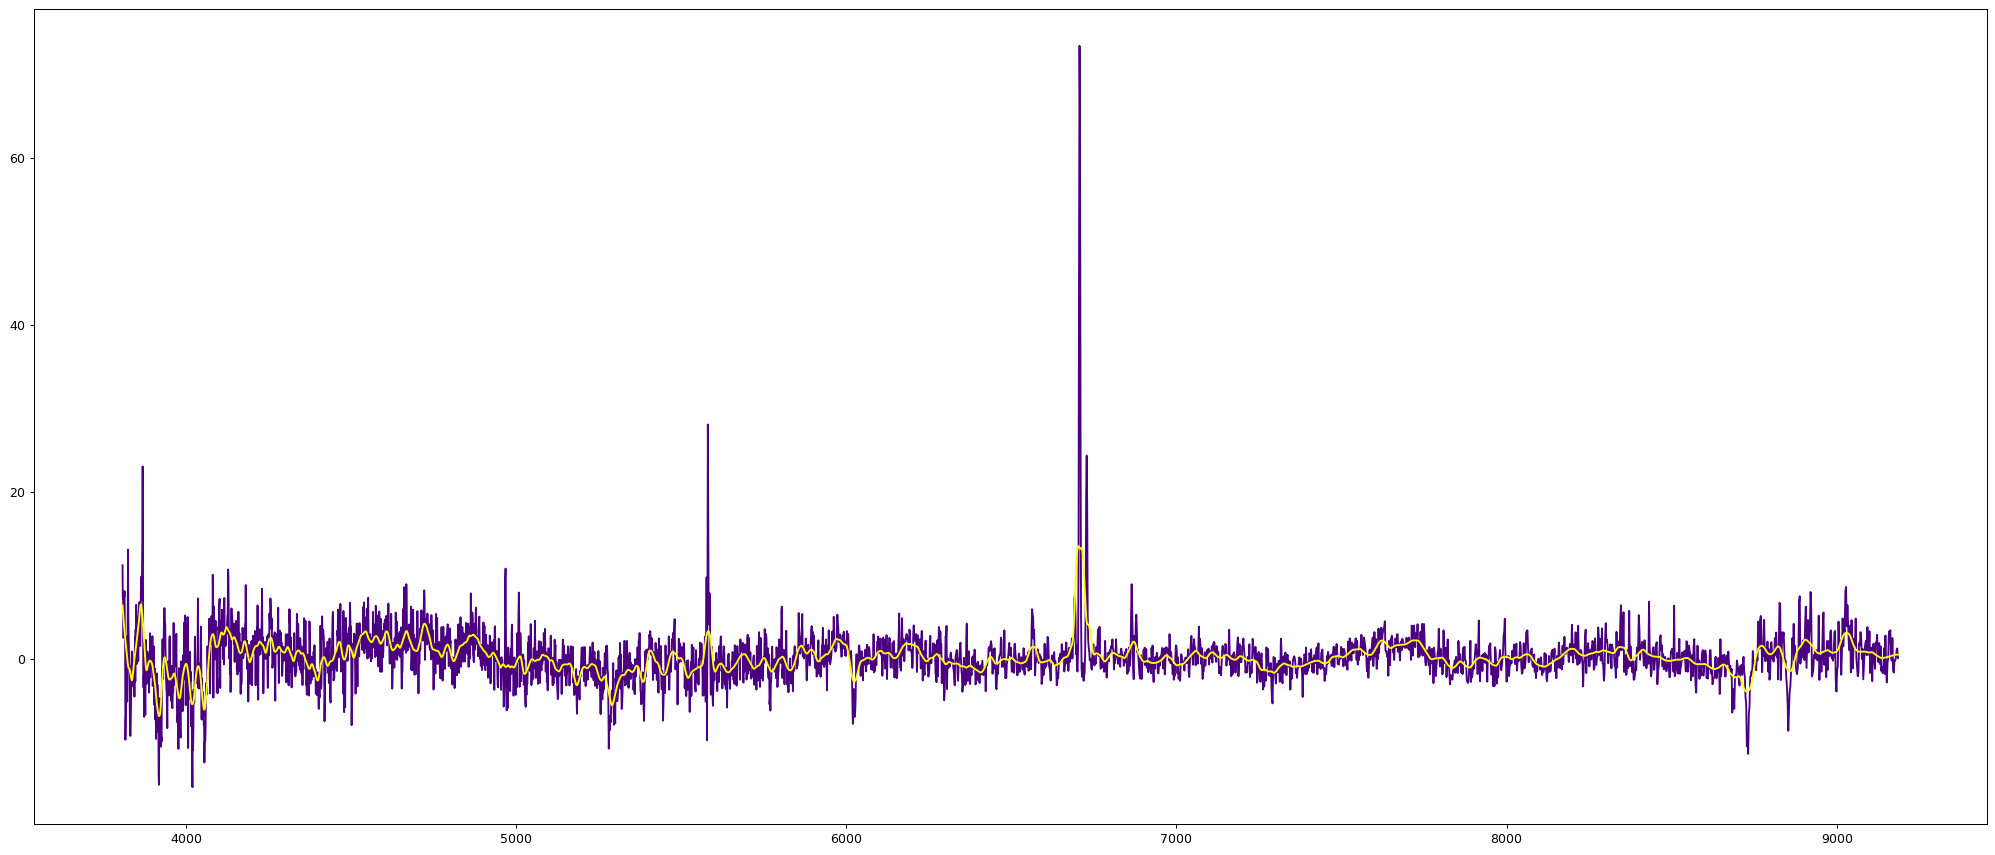

In [18]:
figure(figsize=(28, 12), dpi=90)
plt.plot(x, y, color = 'indigo')
plt.plot(x_l, y_l, color = 'yellow') #то что дальше вычитаем

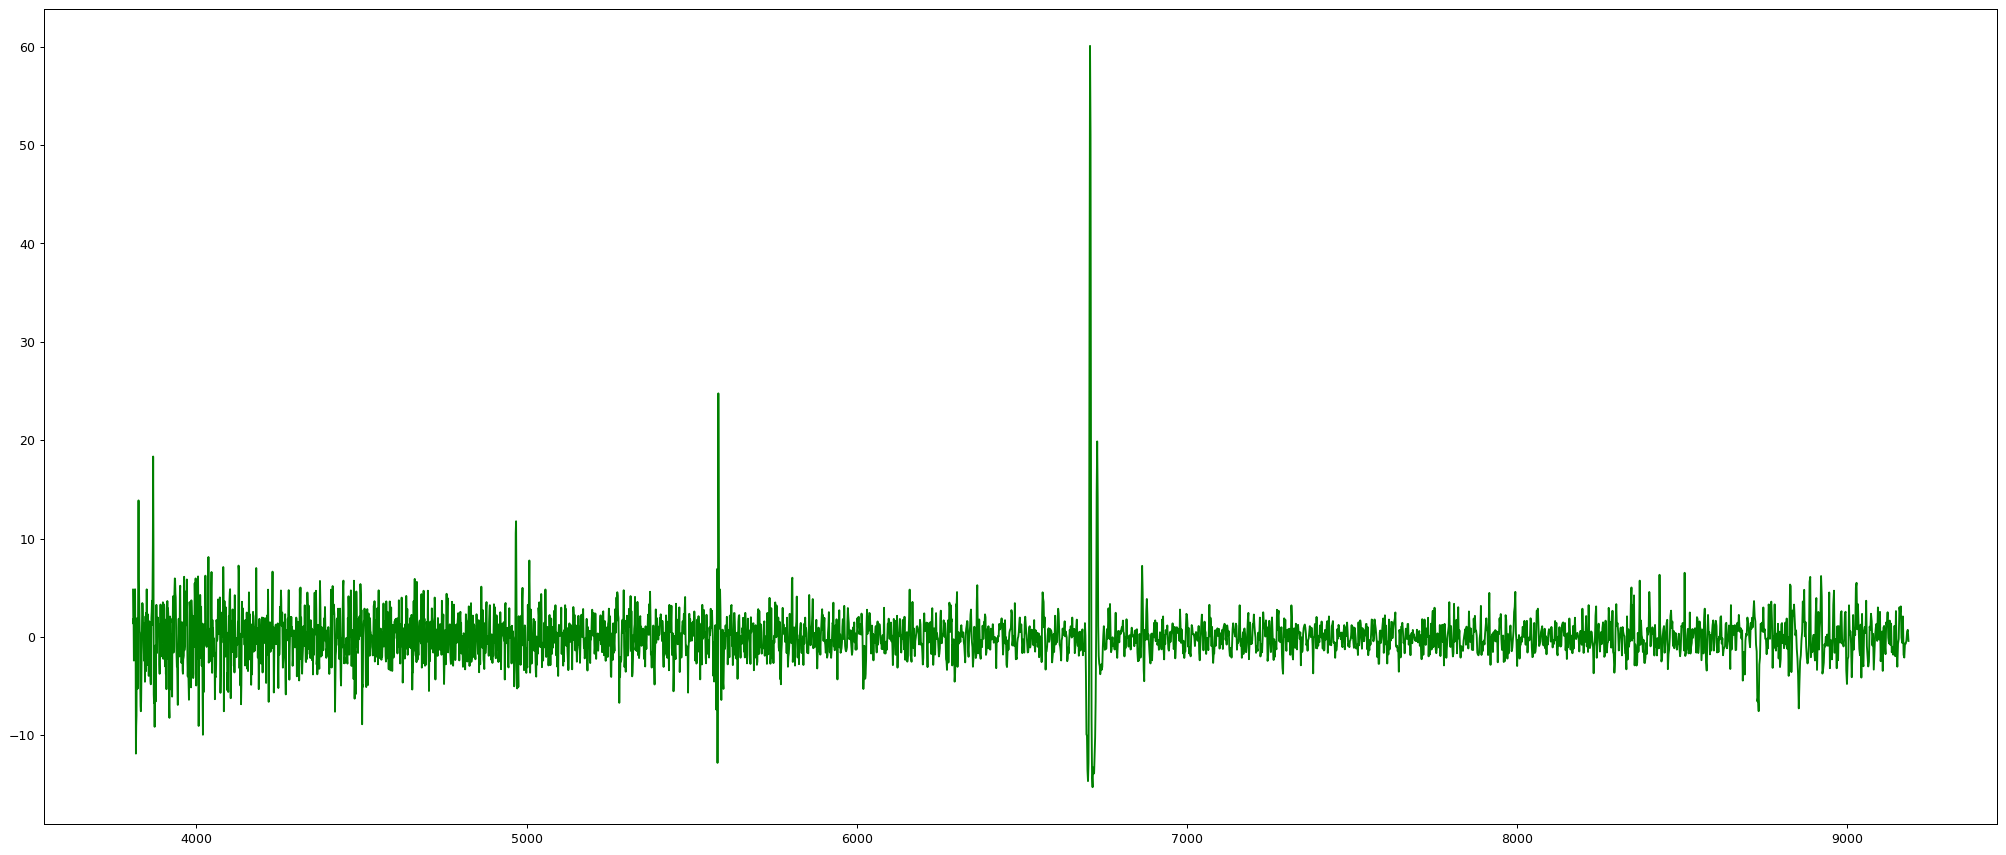

In [19]:
#сглаженная фунция (один раз)
figure(figsize=(28, 12), dpi=90)
plt.plot(x, y-y_l, color = 'green')

In [20]:
data['ivar']

array([0.05175741, 0.05244682, 0.05109984, ..., 0.22849779, 0.23006018,
       0.22683409], dtype=float32)

In [21]:
ivars = data['ivar']
sigmas = (1/ivars) #без корня?
#sigmas_ = 3*sigmas три сигмы? с ними выглядит неправильно

In [22]:
sigmas #похоже, что здесь уже взвешенные значения на три сигмы но это не точно

array([19.320904 , 19.066935 , 19.56953  , ...,  4.37641  ,  4.3466887,
        4.4085083], dtype=float32)

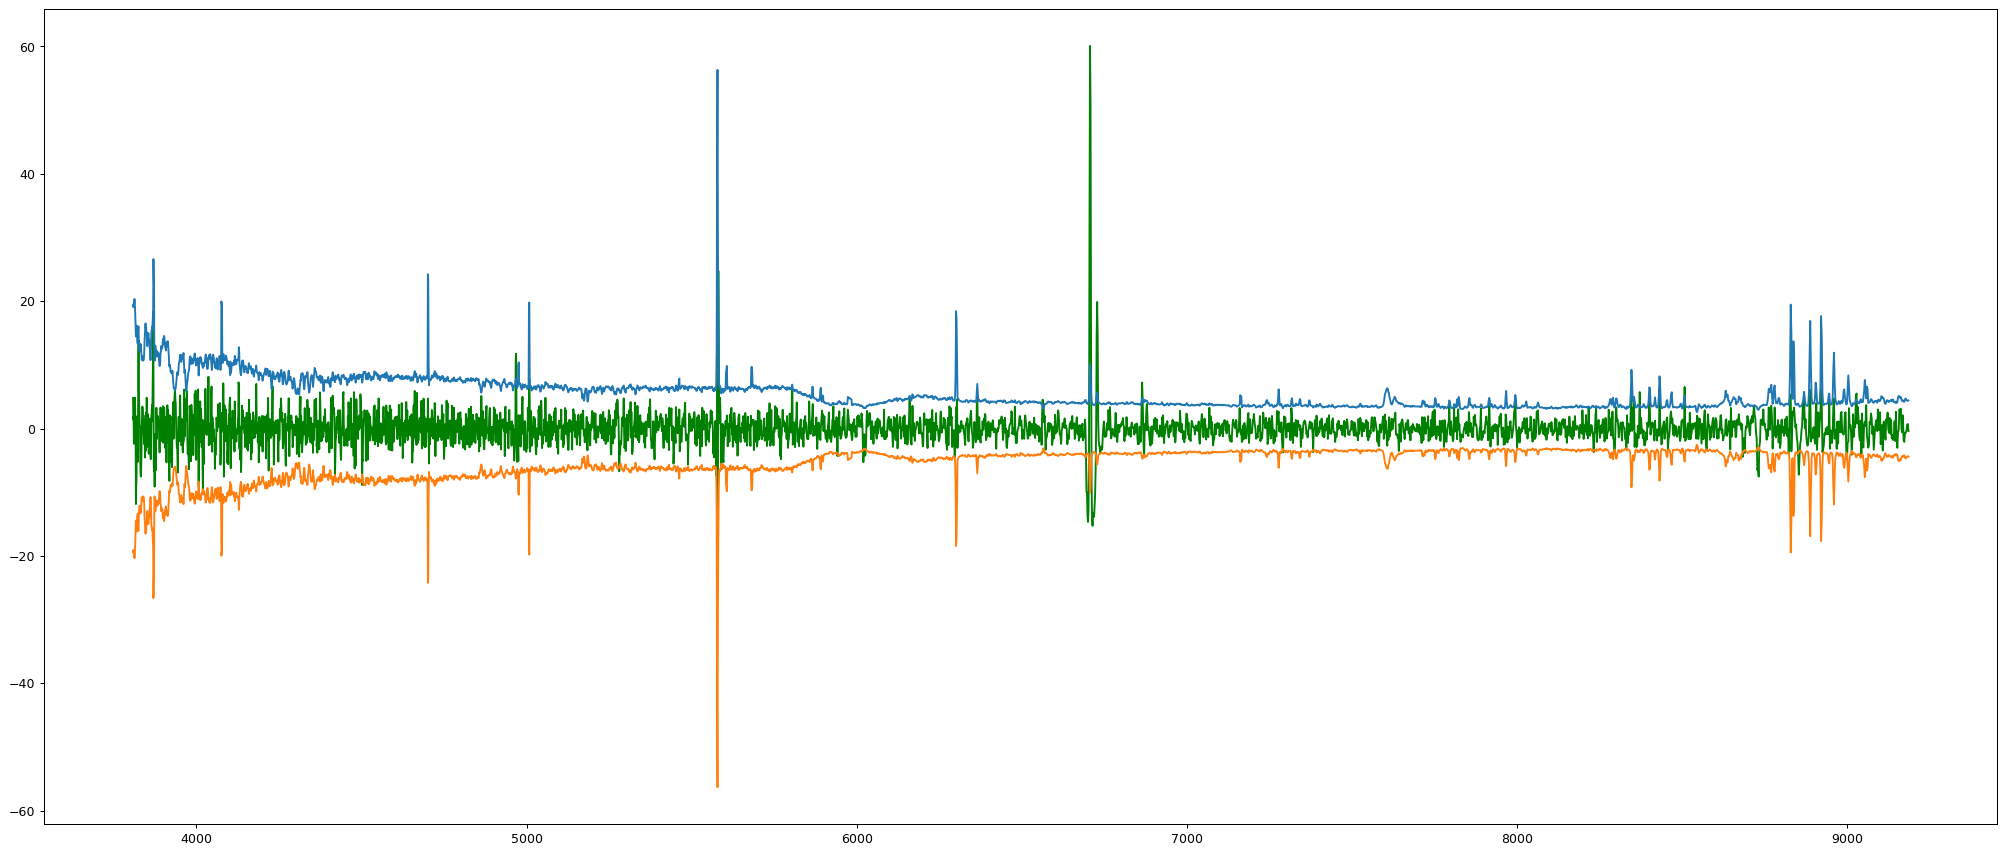

In [23]:
figure(figsize=(28, 12), dpi=90)
plt.plot(x, y-y_l, color = 'green') #сглаженный спектр
plt.plot(x, sigmas) #сигмы
plt.plot(x, -sigmas)

In [24]:
#для эмиссионных
ysmooth = y-y_l
lines_em = []
for k in range(len(ysmooth)):
    if ysmooth[k] > sigmas[k]:
        lines_em.append(x[k])

In [26]:
lines_em #это не сами линни, а все точки, которые их образуют

[4967.067,
 4968.2095,
 5580.846,
 5582.13,
 6562.9644,
 6564.474,
 6565.988,
 6705.0195,
 6706.562,
 6708.1084,
 6709.652,
 6726.6685,
 6728.2163,
 6729.7676,
 6864.3604,
 8371.4375,
 8507.462,
 8717.659,
 9026.095,
 9028.176]